In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib notebook
os.chdir('/Users/apple/Desktop/group/data');
plt.rcParams['figure.figsize'] = (12, 12) # set default size of plots
plt.rcParams.update({'font.size': 18}) # set default font size

Y0=1
RingCull=0
MaxTime=1000

In [2]:
FarmData2001=pd.read_csv('FarmData2001.txt', 
                       names = ["County Number", "Parish Number", "Holding Number", "X Coordinate", "Y Coordinate", "Farm Area", 
                                "Number of Cattle", "Number of Pigs", "Number of Sheep", "Number of Goats", "Number of other Animals"], delim_whitespace=True)
CumbData = FarmData2001[FarmData2001['County Number'] == 8]
CumbData = CumbData.reset_index(drop=True)
CumbData=np.absolute(CumbData)
x=np.array(CumbData['X Coordinate'])
y=np.array(CumbData['Y Coordinate'])
Cows=np.array(CumbData['Number of Cattle'])
Sheep=np.array(CumbData['Number of Sheep'])
XRange=np.max(x)-np.min(x)+1;
YRange=np.max(y)-np.min(y)+1;
N=x.shape[0]
Y0=1;
Status=np.zeros((N,1)); 
Status[0:Y0]=1;
Suscept=Sheep+10.5*Cows; Transmiss=5.1*10**(-7)*Sheep + 7.7*10**(-7)*Cows;

In [3]:
#FarmData2001=np.loadtxt('FarmData2001.txt', usecols=range(11))
#FarmData2001=np.absolute(FarmData2001);
#County=FarmData2001[:,0];
#index=[m for m in range(len(County)) if County[m]==8]
#FarmData=FarmData2001[index,:];
#N=FarmData.shape[0];

#x=FarmData[:,3];
#y=FarmData[:,4];
#XRange=np.max(x)-np.min(x)+1;
#YRange=np.max(y)-np.min(y)+1;
#Size=max(XRange,YRange);
#Y0=1;
#Status=np.zeros((N,1)); 
#Status[0:Y0]=1;
#Cows=FarmData[:,6];Sheep=FarmData[:,8];
#Suscept=Sheep+10.5*Cows; Transmiss=5.1*10**(-7)*Sheep + 7.7*10**(-7)*Cows;

In [4]:
def WhichGrid(x,y,XRange,YRange,XNum,YNum):
    G=np.floor(x*XNum/XRange)*YNum+np.floor(y*YNum/YRange)+1
    return G

In [5]:
grid=WhichGrid(x-min(x),y-min(y),XRange,YRange,10,10)

In [6]:
index=np.argsort(grid,axis=0)
#index=index.flatten()

In [7]:
x=x[index]
y=y[index]
Status=Status[index]
grid=grid[index]

In [8]:
Xgrid=np.zeros((int(np.max(grid)),1))
Ygrid=np.zeros((int(np.max(grid)),1))
Num=np.zeros((int(np.max(grid)),1))
first_in_grid=np.zeros((int(np.max(grid)),1))
last_in_grid=np.zeros((int(np.max(grid)),1))
Max_Sus_grid=np.zeros((int(np.max(grid)),1))

In [9]:
for i in range(int(np.max(grid))):
    Xgrid[i]=np.floor(i/10.0);
    Ygrid[i]=i%10;
    m=[j for j in range(len(grid)) if grid[j]==(i+1)];
    Num[i]=len(m)
    if Num[i]>0:
        first_in_grid[i]=np.min(m)
        last_in_grid[i]=np.max(m)
        Max_Sus_grid[i]=np.max(Suscept[m])
    else:
        first_in_grid[i]=0
        last_in_grid[i]=-1
        Max_Sus_grid[i]=0

In [10]:
def Kernel(Dist2):
    Dist2=[x*(20**2+20**2)/(XRange**2+YRange**2) for x in Dist2]
    P=[-9.2123*10**(-5),9.5628*10**(-4),3.3966*10**(-3),-3.3687*10**(-2),-1.30519*10**(-1),-0.609262,-3.231772];
    K=np.array(np.exp(np.polyval(P,Dist2)))
    index1=[i for i in range(len(Dist2)) if Dist2[i]<0.0138]
    index2=[i for i in range(len(Dist2)) if Dist2[i]>60*60]
    K[index1]=0.3093
    K[index2]=0
    return K

In [11]:
MaxRate=np.zeros((int(np.max(grid)),int(np.max(grid))))
for i in range(int(np.max(grid))):
    for j in range(int(np.max(grid))):
        if (i==j) or (Num[i]==0) or (Num[j]==0):
            MaxRate[i,j]=float('inf')
        else:
            # not use size
            Dist2=(XRange*np.max([0,abs(Xgrid[i]-Xgrid[j])-1])/10.0)**2+(YRange*np.max([0,abs(Ygrid[i]-Ygrid[j])-1])/10.0)**2
            MaxRate[i,j]=Max_Sus_grid[j]*Kernel([Dist2])

In [12]:
def Iterate(Status,x,y,Suscept,Transmiss,RingCull,grid,first_in_grid,last_in_grid,Num,MaxRate):
    Event=0*Status
    INF=[i for i in range(len(Status)) if (Status[i]>5) and (Status[i]<12)]
    NI=len(INF)
    IGrids=grid[INF]
    for i in range(NI):
        INFi=INF[i]
        MaxProb=1-np.exp(-Transmiss[INFi]*np.multiply(np.transpose(Num),MaxRate[int(IGrids[i]-1),:]))
        Rand1=np.random.uniform(0,1,(1,int(max(grid))))
        m=[i for i in range(len(MaxProb[0])) if (MaxProb[0][i]>Rand1[0][i])]
        for n in range(len(m)):
            s=1
            M=m[n]
            PAB=1-np.exp(-Transmiss[INFi]*MaxRate[int(IGrids[0]-1),M])
            if PAB==1:
                ind=np.arange(first_in_grid[M],last_in_grid[M]+1,1)
                ind=map(int,ind)
                Q=1-np.exp(-Transmiss[INFi]*np.multiply(Suscept[ind],Kernel((x[INFi]-x[ind])**2+(y[INFi]-y[ind])**2)))
                Rand2=np.random.uniform(0,1,Q.shape)
                index=[i for i in range(len(Q)) if (Rand2[i]<Q[i]) and (Status[ind[i]]==0)]
                Event[np.array(ind)[index]]=1
            else:
                for j in range(Num[M]):
                    ind=first_in_grid[M]+j-1
                    ind=map(int,ind)
                    P=1-s*np.power((1-PAB),Num[M]+1-j)
                    R=np.random.uniform(0,1,1)
                    if (P==0):
                        s=0
                        if (Status[ind]==0):
                            Event[ind]=1
                    elif (R<PAB/P):
                        s=0
                        Q=1-np.exp(-Transmiss[INFi]*np.multiply(Suscept[ind],Kernel((x[INFi]-x[ind])**2+(y[INFi]-y[ind])**2)))
                        if (R<Q/P) and (Status[ind]==0):
                            Event[ind]=1
    m=[i for i in range(len(Status)) if Status[i]>0]
    Status[m]=Status[m]+1
    Status=Status+Event
    
    m=[i for i in range(len(Status)) if Status[i]==13]
    for i in range(len(m)):
        Status[m[i]]=-1
        D=np.power(x[m[i]]-x,2)+np.power(y[m[i]]-y,2)
        n=[i for i in range(len(x)) if D[i]<RingCull**2]
        Status[n]=-1
    return Status

<IPython.core.display.Javascript object>


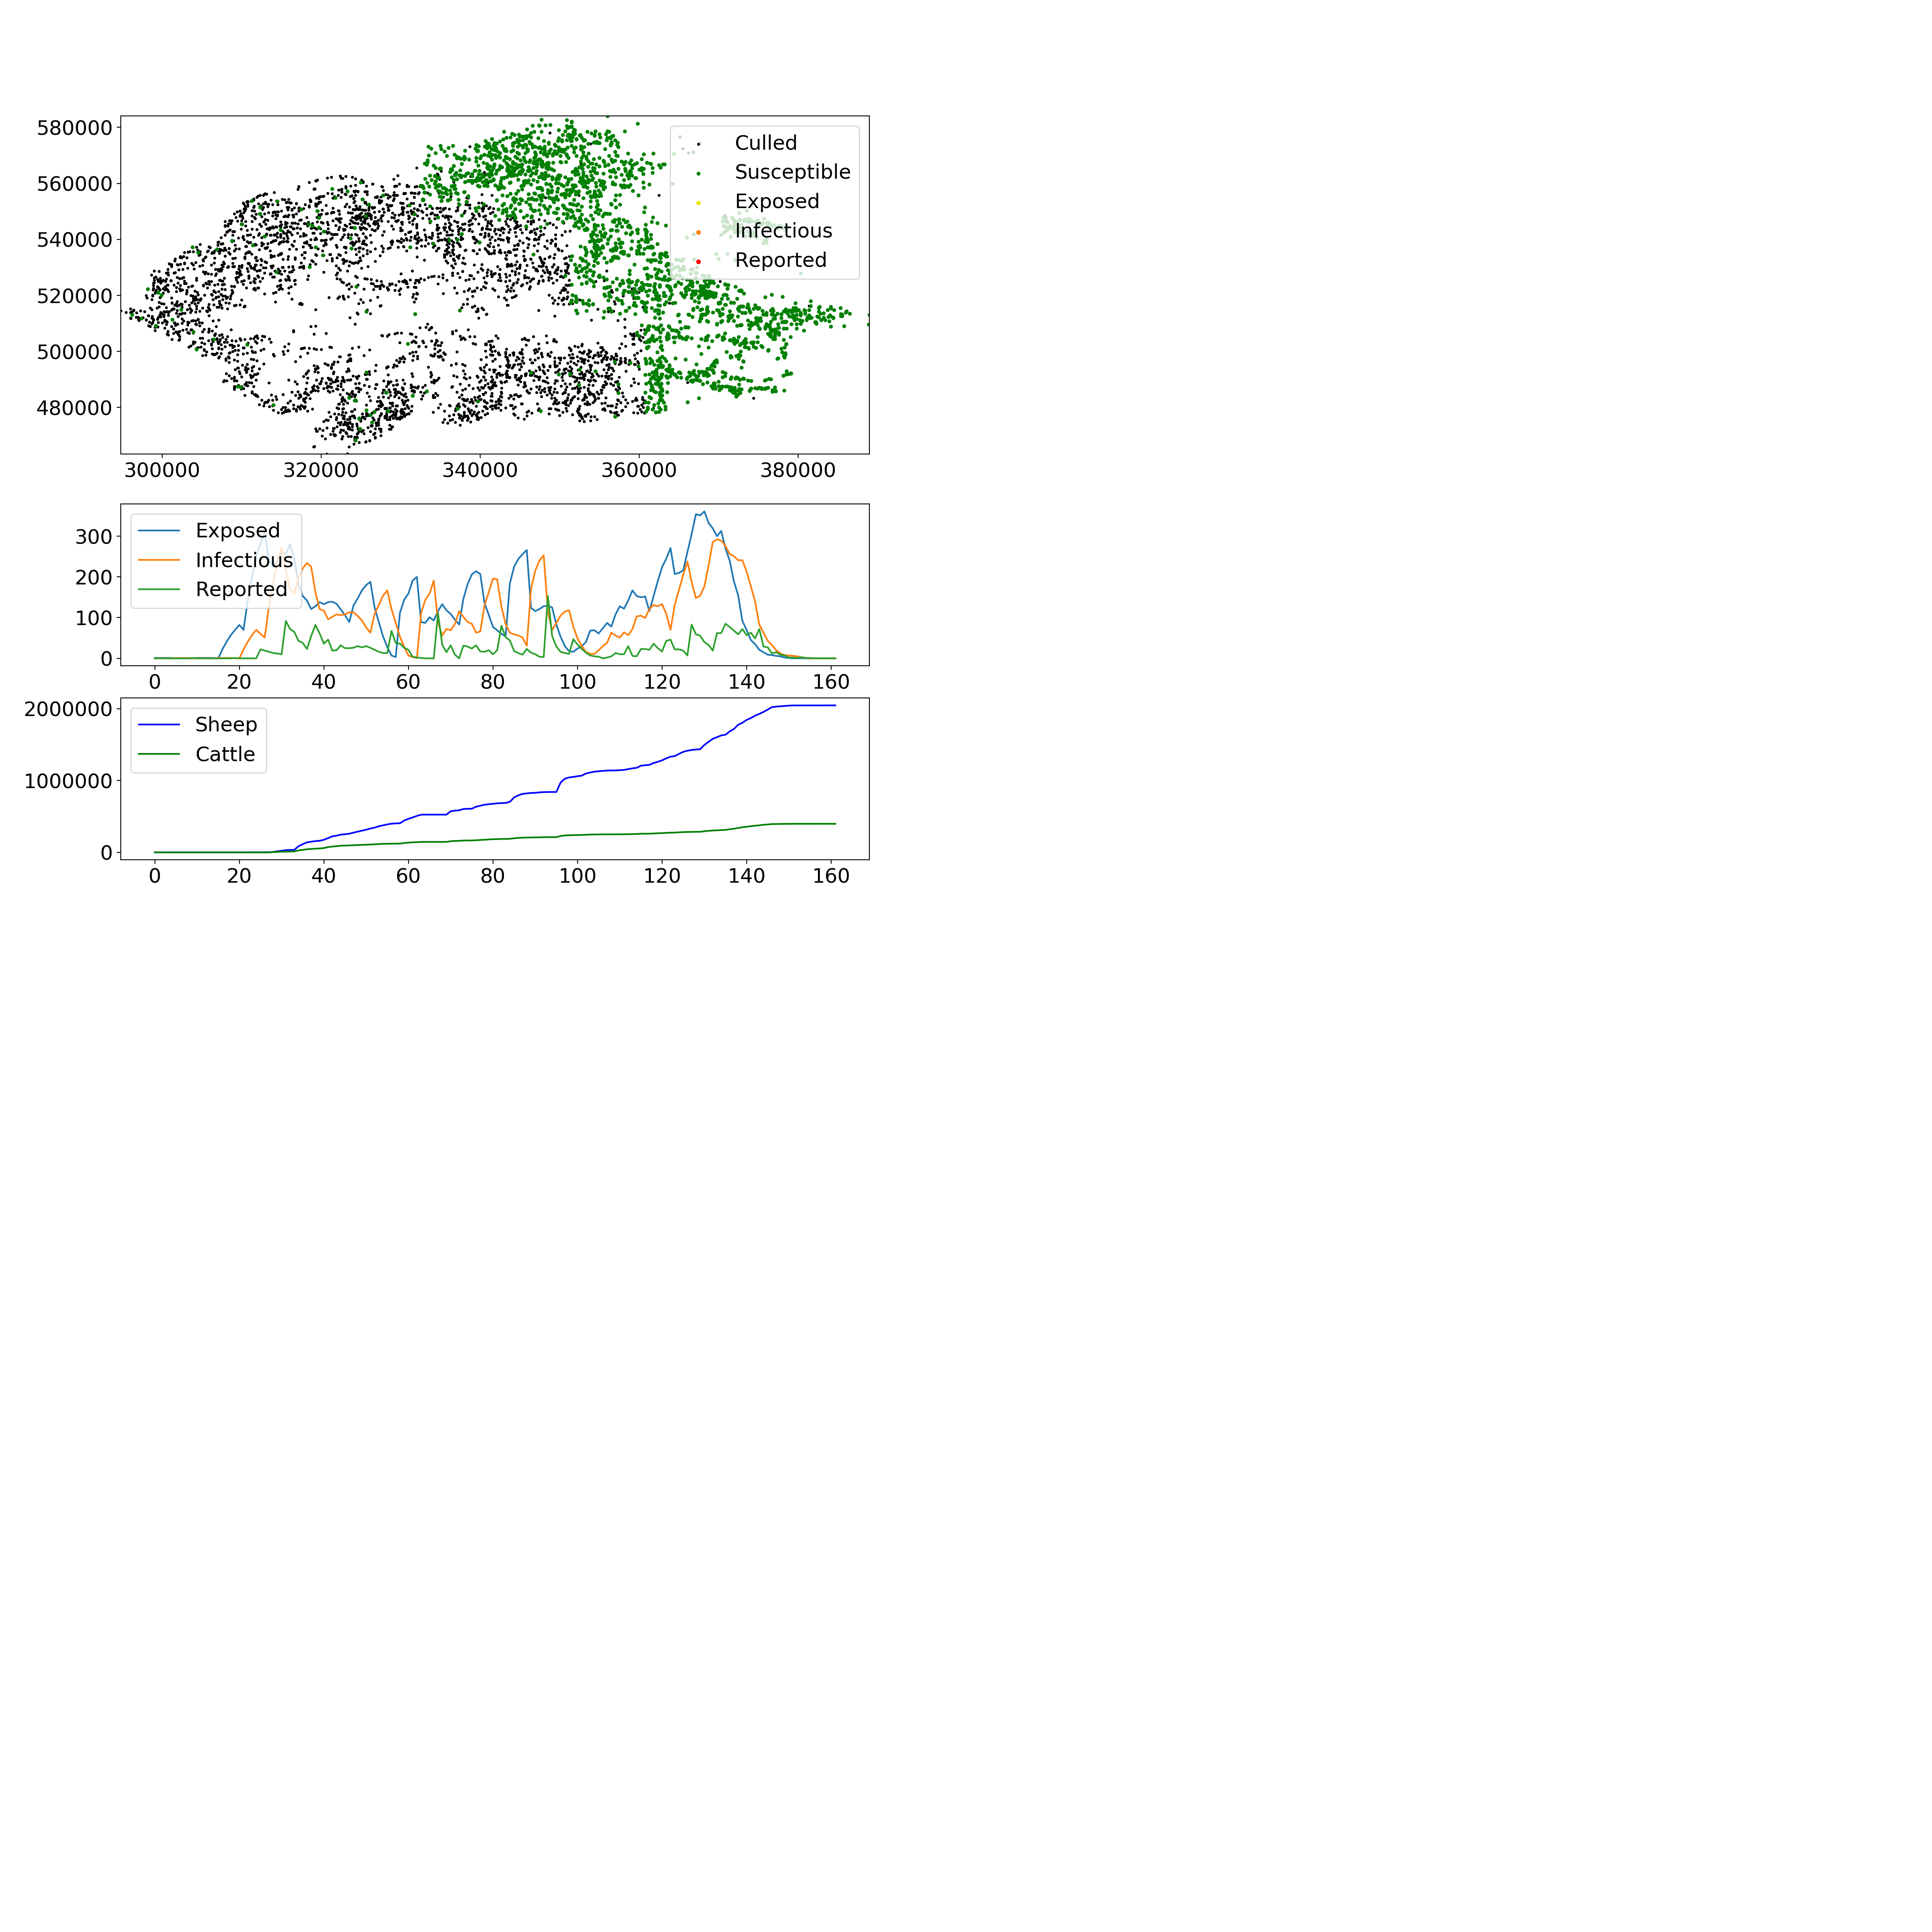

/Users/apple/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


In [13]:
t=[0]
S=[len([i for i in range(len(Status)) if Status[i]==0])]
E=[len([i for i in range(len(Status)) if (Status[i]>0) and (Status[i]<=5)])]
I=[len([i for i in range(len(Status)) if (Status[i]>5) and (Status[i]<=9)])]
R=[len([i for i in range(len(Status)) if Status[i]==10])]
R2=[len([i for i in range(len(Status)) if Status[i]>9])]
CullSheep=[0]
CullCattle=[0]
IterateFlag=1

fig = plt.figure()
ax = fig.add_subplot(211)
ax1 = fig.add_subplot(413)
ax2 = fig.add_subplot(414)
plt.ion
fig.show()
fig.canvas.draw()

while (t[-1]<MaxTime) and (IterateFlag):
    Status=Iterate(Status,x,y,Suscept,Transmiss,RingCull,grid,first_in_grid,last_in_grid,Num,MaxRate)
    Sus=[i for i in range(len(Status)) if Status[i]==0]
    Exp=[i for i in range(len(Status)) if (Status[i]>0) and (Status[i]<=5)]
    Inf=[i for i in range(len(Status)) if (Status[i]>5) and (Status[i]<=9)]
    Rep=[i for i in range(len(Status)) if Status[i]==10]
    Rep2=[i for i in range(len(Status)) if Status[i]>9]
    Culled=[i for i in range(len(Status)) if Status[i]<0]
    S.append(len(Sus))
    E.append(len(Exp))
    I.append(len(Inf))
    R.append(len(Rep))
    R2.append(len(Rep2))
    CullSheep.append(np.sum(Sheep[Culled]))
    CullCattle.append(np.sum(Cows[Culled]))
    t.append(t[-1]+1)
    
    if t[-1]>5:
        if E[-4]+I[-4]+R2[-4]==0:
            IterateFlag=0
    
  
    
    ax.clear()
    ax1.clear()
    ax2.clear()
    
    ax.scatter(x[Culled],y[Culled], c='k', marker='.', s=10, label='Culled')
    ax.scatter(x[Sus],y[Sus], c='g', marker='o', s=6, label='Susceptible')
    ax.scatter(x[Exp],y[Exp], c=[0.9, 0.9, 0], marker='o', s=8, label='Exposed')
    ax.scatter(x[Inf],y[Inf], c=[1, 0.5, 0], marker='o', s=10, label='Infectious')
    ax.scatter(x[Rep],y[Rep], c='r', marker='o', s=10, label='Reported')
    ax.axis([min(x), max(x), min(y), max(y)])
    ax.legend()
    
    ax1.plot(t,E,label='Exposed')
    ax1.plot(t,I,label='Infectious')
    ax1.plot(t,R,label='Reported')
    ax1.legend()
    #ax1.ylabel('Total Infected')
    
    
    ax2.plot(t,CullSheep,'-b',label='Sheep')
    ax2.plot(t,CullCattle,'-g',label='Cattle');
    ax2.legend()
    #ax2.ylabel('Total Animals Culled')
    #ax2.xlabel('Time (days)')
    fig.canvas.draw()
    
    #plt.pause(0.5)
            
    

In [14]:
S

[6214,
 6214,
 6214,
 6214,
 6214,
 6214,
 6214,
 6214,
 6214,
 6214,
 6213,
 6213,
 6213,
 6213,
 6213,
 6213,
 6191,
 6172,
 6156,
 6143,
 6131,
 6121,
 6029,
 5957,
 5892,
 5849,
 5811,
 5788,
 5733,
 5651,
 5590,
 5554,
 5508,
 5489,
 5469,
 5437,
 5412,
 5387,
 5361,
 5331,
 5304,
 5274,
 5248,
 5227,
 5211,
 5198,
 5185,
 5118,
 5080,
 5044,
 5018,
 4997,
 4993,
 4991,
 4990,
 4990,
 4990,
 4990,
 4879,
 4846,
 4831,
 4799,
 4790,
 4790,
 4759,
 4730,
 4706,
 4674,
 4657,
 4641,
 4621,
 4611,
 4591,
 4511,
 4459,
 4415,
 4397,
 4384,
 4375,
 4352,
 4338,
 4328,
 4324,
 4321,
 4168,
 4113,
 4084,
 4068,
 4055,
 4044,
 3997,
 3963,
 3940,
 3926,
 3919,
 3914,
 3910,
 3910,
 3908,
 3903,
 3890,
 3880,
 3870,
 3840,
 3834,
 3829,
 3806,
 3783,
 3762,
 3726,
 3701,
 3684,
 3641,
 3595,
 3573,
 3551,
 3532,
 3525,
 3442,
 3383,
 3327,
 3287,
 3254,
 3235,
 3173,
 3111,
 3026,
 2949,
 2881,
 2822,
 2750,
 2693,
 2630,
 2581,
 2509,
 2480,
 2453,
 2441,
 2426,
 2417,
 2410,
 2408,
 2406,

In [15]:
I

[0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 22,
 41,
 57,
 70,
 60,
 51,
 127,
 186,
 239,
 272,
 218,
 169,
 159,
 198,
 221,
 234,
 225,
 162,
 121,
 117,
 96,
 102,
 108,
 106,
 108,
 113,
 113,
 104,
 93,
 76,
 63,
 109,
 131,
 154,
 167,
 121,
 87,
 53,
 28,
 7,
 3,
 1,
 111,
 144,
 159,
 191,
 89,
 56,
 72,
 69,
 84,
 116,
 102,
 89,
 85,
 63,
 66,
 130,
 162,
 196,
 194,
 127,
 84,
 63,
 59,
 56,
 51,
 31,
 170,
 215,
 240,
 253,
 113,
 69,
 87,
 105,
 115,
 118,
 78,
 49,
 30,
 16,
 11,
 11,
 20,
 30,
 38,
 63,
 56,
 51,
 64,
 57,
 72,
 103,
 105,
 99,
 121,
 131,
 128,
 133,
 109,
 70,
 131,
 168,
 205,
 238,
 188,
 148,
 154,
 176,
 228,
 286,
 292,
 289,
 276,
 256,
 251,
 241,
 241,
 213,
 177,
 140,
 83,
 63,
 43,
 33,
 20,
 12,
 8,
 7,
 6,
 5,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [16]:
E

[1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 22,
 41,
 57,
 70,
 82,
 70,
 143,
 199,
 251,
 282,
 310,
 241,
 224,
 241,
 259,
 257,
 280,
 244,
 182,
 153,
 142,
 121,
 128,
 138,
 133,
 138,
 139,
 134,
 120,
 106,
 89,
 130,
 147,
 167,
 180,
 188,
 125,
 89,
 54,
 28,
 7,
 3,
 112,
 144,
 159,
 191,
 200,
 89,
 87,
 101,
 93,
 116,
 133,
 118,
 109,
 95,
 83,
 146,
 182,
 206,
 214,
 207,
 136,
 107,
 77,
 69,
 60,
 54,
 184,
 225,
 244,
 256,
 266,
 124,
 116,
 121,
 128,
 129,
 125,
 83,
 53,
 30,
 18,
 16,
 24,
 30,
 40,
 68,
 69,
 61,
 74,
 87,
 78,
 108,
 128,
 122,
 142,
 167,
 153,
 150,
 152,
 116,
 153,
 190,
 224,
 245,
 271,
 207,
 210,
 216,
 261,
 305,
 354,
 351,
 361,
 333,
 319,
 300,
 313,
 270,
 240,
 189,
 155,
 92,
 70,
 45,
 35,
 21,
 15,
 9,
 8,
 6,
 5,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [17]:
R

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 22,
 19,
 16,
 13,
 12,
 10,
 92,
 72,
 65,
 43,
 38,
 23,
 55,
 82,
 61,
 36,
 46,
 19,
 20,
 32,
 25,
 25,
 26,
 30,
 27,
 30,
 26,
 21,
 16,
 13,
 13,
 67,
 38,
 36,
 26,
 21,
 4,
 2,
 1,
 0,
 0,
 0,
 111,
 33,
 15,
 32,
 9,
 0,
 31,
 29,
 24,
 32,
 17,
 16,
 20,
 10,
 20,
 80,
 52,
 44,
 18,
 13,
 9,
 23,
 14,
 10,
 4,
 3,
 153,
 55,
 29,
 16,
 13,
 11,
 47,
 34,
 23,
 14,
 7,
 5,
 4,
 0,
 2,
 5,
 13,
 10,
 10,
 30,
 6,
 5,
 23,
 23,
 21,
 36,
 25,
 17,
 43,
 46,
 22,
 22,
 19,
 7,
 83,
 59,
 56,
 40,
 33,
 19,
 62,
 62,
 85,
 77,
 68,
 59,
 72,
 57,
 63,
 49,
 72,
 29,
 27,
 12,
 15,
 9,
 7,
 2,
 2,
 1,
 3,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0]

In [18]:
R2

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 22,
 41,
 57,
 48,
 41,
 35,
 114,
 174,
 229,
 180,
 146,
 104,
 116,
 160,
 198,
 179,
 143,
 101,
 85,
 71,
 77,
 82,
 76,
 81,
 83,
 87,
 83,
 77,
 63,
 50,
 42,
 93,
 118,
 141,
 100,
 83,
 51,
 27,
 7,
 3,
 1,
 0,
 111,
 144,
 159,
 80,
 56,
 41,
 40,
 60,
 84,
 85,
 73,
 65,
 53,
 46,
 50,
 110,
 152,
 176,
 114,
 75,
 40,
 45,
 46,
 47,
 28,
 17,
 160,
 211,
 237,
 100,
 58,
 40,
 71,
 92,
 104,
 71,
 44,
 26,
 16,
 9,
 6,
 7,
 20,
 28,
 33,
 50,
 46,
 41,
 34,
 51,
 67,
 80,
 82,
 78,
 85,
 106,
 111,
 90,
 63,
 48,
 109,
 149,
 198,
 155,
 129,
 92,
 114,
 143,
 209,
 224,
 230,
 204,
 199,
 188,
 192,
 169,
 184,
 150,
 128,
 68,
 54,
 36,
 31,
 18,
 11,
 5,
 6,
 5,
 5,
 2,
 1,
 0,
 0,
 0,
 0]

In [19]:
CullSheep

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 759,
 759,
 759,
 759,
 759,
 759,
 5857,
 15538,
 22403,
 30944,
 34238,
 34984,
 85685,
 114932,
 139235,
 148831,
 157128,
 161603,
 175440,
 198717,
 223937,
 232227,
 247486,
 252226,
 260132,
 274747,
 288429,
 302145,
 315699,
 331426,
 344666,
 363997,
 376227,
 389408,
 398955,
 403930,
 405318,
 443190,
 467046,
 486311,
 507297,
 524355,
 525362,
 525384,
 525394,
 525394,
 525394,
 525394,
 572238,
 581005,
 585123,
 603469,
 606882,
 606882,
 635156,
 649310,
 662964,
 670052,
 676344,
 682636,
 685427,
 688283,
 703125,
 764132,
 794170,
 813942,
 820830,
 826353,
 828565,
 835351,
 838404,
 840188,
 840247,
 840332,
 972469,
 1024759,
 1042677,
 1050116,
 1059952,
 1067185,
 1097576,
 1111212,
 1122674,
 1128959,
 1133979,
 1138194,
 1139754,
 1139754,
 1144121,
 1146896,
 1158787,
 1169246,
 1176480,
 1206314,
 1212619,
 1217802,
 1243730,
 1260335,
 1280658,
 1308218,
 1331824,
 13

In [20]:
CullCattle

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 337,
 337,
 337,
 337,
 337,
 337,
 3844,
 6431,
 9547,
 10800,
 12137,
 13235,
 27383,
 34586,
 43885,
 47674,
 52476,
 54463,
 60571,
 73175,
 81644,
 86454,
 92598,
 95114,
 96847,
 99522,
 101733,
 104382,
 107155,
 109966,
 112163,
 115610,
 119089,
 120039,
 121351,
 121889,
 122669,
 131113,
 135625,
 139679,
 142722,
 145535,
 145823,
 145823,
 145823,
 145823,
 145823,
 145823,
 155862,
 159818,
 160641,
 165205,
 165563,
 165563,
 168771,
 172671,
 175882,
 180366,
 183172,
 184464,
 186488,
 187373,
 189366,
 196754,
 201605,
 204844,
 206448,
 207631,
 208749,
 210333,
 211554,
 212102,
 212297,
 212354,
 228046,
 235435,
 238417,
 239672,
 241161,
 242004,
 245685,
 247738,
 248696,
 249998,
 250575,
 250650,
 251244,
 251244,
 251594,
 252177,
 253346,
 254824,
 255748,
 259424,
 259907,
 260246,
 263405,
 266255,
 268021,
 271522,
 274073,
 275222,
 278696,
 282438,
 284126,
 284815,

In [21]:
t

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161]